<a href="https://colab.research.google.com/github/TheKypers/2024-null-name-IgnaGM/blob/master/Sentiment_Analysis_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
def load_df(fp):
	df= pd.read_csv(fp, names=['id', 'ip', 'sentiment', 'text']).set_index('id')
	df.drop_duplicates(inplace=True)
	df.dropna(inplace=True)
	#df.info()
	return df

load datos google drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/My Drive/collab test modelos/

/content/drive/My Drive/collab test modelos


In [8]:
!ls "/content/drive/My Drive/collab test modelos/"

twitter_training.csv  twitter_validation.csv


#Cargar la data

In [9]:
df_trn= load_df('twitter_training.csv')
df_tst= load_df('twitter_validation.csv')
df_trn

,ip,sentiment,text
id,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...
9200,Nvidia,Positive,Just realized that the Windows partition of my...
9200,Nvidia,Positive,Just realized that my Mac window partition is ...
9200,Nvidia,Positive,Just realized the windows partition of my Mac ...


# Exploratory data analysis (EDA) y visualizacion de los datos

Debido a que nuestro modelo no se basa en valores discretos individuales sino en conjuntos de valores discretos asociados que definen palabras, estos no se pueden visualizar de manera tan simple. Es por esto que haremos un analisis estadistico sobre el las palabras mas usadas y la conotacion de estas.

Distribucion de tamaño de palabras

Distribucion de los labels de las observaciones

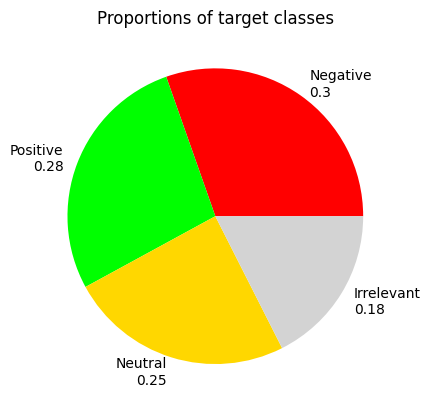

In [10]:
target_balance = df_trn['sentiment'].value_counts()

plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(df_trn), 2)}' for idx in target_balance.index],
        colors=['red', 'lime', 'gold', 'lightgray'])
plt.title('Proportions of target classes')
plt.show()

Busco las palabras mas importantes de los positivos

In [11]:
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
%%capture
from nltk.corpus import stopwords
stopwords.words("english")

In [13]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

word_counts = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(df_trn['text'], df_trn['sentiment']):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)

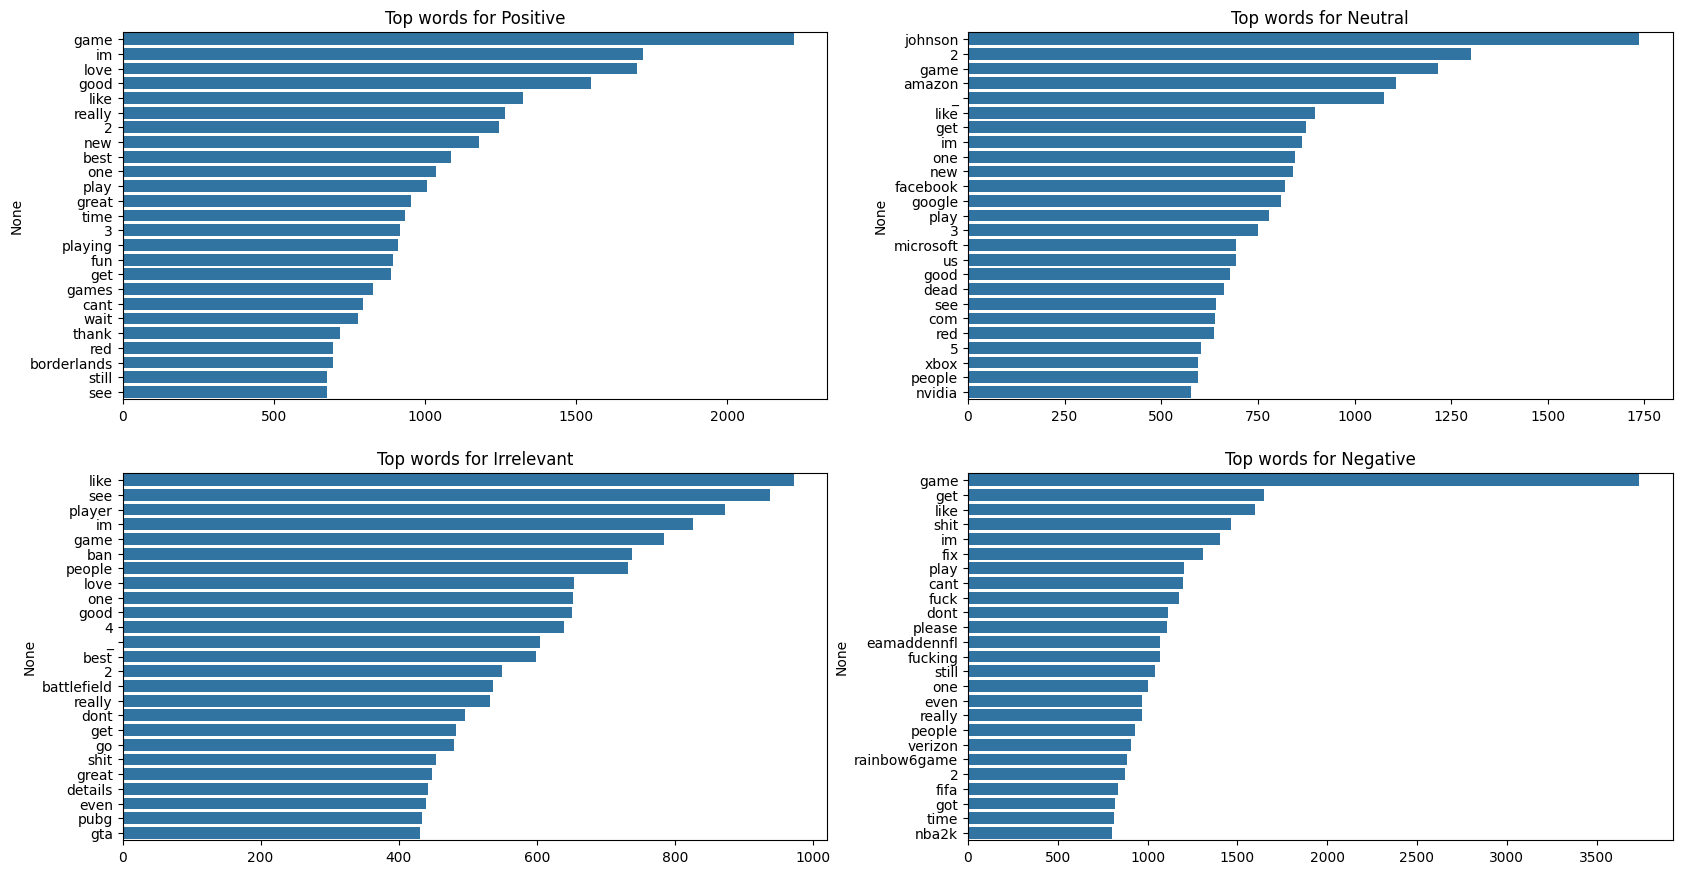

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

And we also analyze the most correlated words with the sentiments

# PRE PROCCESING DATA

## Filtro las irrelevantes

In [15]:
df_trn= df_trn[df_trn['sentiment']!='Irrelevant']
df_tst = df_tst[df_tst['sentiment']!='Irrelevant']

df_trn= df_trn[df_trn['sentiment']!='Neutral']
df_tst = df_tst[df_tst['sentiment']!='Neutral']

## Sacar caracteres especiales como emojis




In [16]:
!pip install emoji

In [17]:
import emoji
def remove_emoji(text):
    return emoji.replace_emoji(text, '')

In [18]:
df_trn['text']= df_trn['text'].apply(remove_emoji)
df_tst['text']= df_tst['text'].apply(remove_emoji)
df_trn

,ip,sentiment,text
id,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...
9200,Nvidia,Positive,Just realized that the Windows partition of my...
9200,Nvidia,Positive,Just realized that my Mac window partition is ...
9200,Nvidia,Positive,Just realized the windows partition of my Mac ...


## Remover IPs para que no tengan conotaciones positivas o negativas

In [19]:
exclude = df_trn['ip'].str.lower().unique()     #Nombres de Ip con minuscula
exclude = np.append(exclude,df_trn['ip'].unique())    #Nombres de Ip con mayuscula

def remove_IPs(text):
    for char in exclude:
        text=text.replace(char,'')
    return text

In [20]:
df_trn['text'] = df_trn['text'].apply(remove_IPs)

df_trn

,ip,sentiment,text
id,,,
2401,Borderlands,Positive,"im getting on and i will murder you all ,"
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,"im getting on and i will kill you all,"
2401,Borderlands,Positive,"im coming on and i will murder you all,"
2401,Borderlands,Positive,"im getting on 2 and i will murder you me all,"
...,...,...,...
9200,Nvidia,Positive,Just realized that the Windows partition of my...
9200,Nvidia,Positive,Just realized that my Mac window partition is ...
9200,Nvidia,Positive,Just realized the windows partition of my Mac ...


## Sacar los links

In [21]:
import re
def remove_url(text):
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)
    text = re.sub(r'pic.twitter.com / [\w]*',"", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    return text


In [22]:
df_trn['text'] = df_trn['text'].apply(remove_url)
df_trn

,ip,sentiment,text
id,,,
2401,Borderlands,Positive,"im getting on and i will murder you all ,"
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,"im getting on and i will kill you all,"
2401,Borderlands,Positive,"im coming on and i will murder you all,"
2401,Borderlands,Positive,"im getting on 2 and i will murder you me all,"
...,...,...,...
9200,Nvidia,Positive,Just realized that the Windows partition of my...
9200,Nvidia,Positive,Just realized that my Mac window partition is ...
9200,Nvidia,Positive,Just realized the windows partition of my Mac ...


## Guardar cantidad de mayusculas por tweet

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
%%capture
from nltk.corpus import stopwords
stopwords.words("english")

In [25]:
# prompt: count_uppercases

def count_uppercases(text):
    count = 0
    for char in text:
        if char.isupper():
            count += 1
    return count

In [26]:
df_trn['upper_count'] = df_trn['text'].apply(count_uppercases)
df_trn.head()

,ip,sentiment,text,upper_count
id,,,,
2401,Borderlands,Positive,"im getting on and i will murder you all ,",0
2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2
2401,Borderlands,Positive,"im getting on and i will kill you all,",0
2401,Borderlands,Positive,"im coming on and i will murder you all,",0
2401,Borderlands,Positive,"im getting on 2 and i will murder you me all,",0


## Pasar todo a minuscula


In [27]:
df_trn['text'] = df_trn['text'].str.lower()
df_tst['text'] = df_tst['text'].str.lower()

##Sacar dobles espacios

In [28]:
def remove_double_space(text):
    return ' '.join(text.split())

In [29]:
df_trn['text'] = df_trn['text'].apply(remove_double_space)

In [30]:
df_trn['text'].head()

,text
id,
2401,"im getting on and i will murder you all ,"
2401,i am coming to the borders and i will kill you...
2401,"im getting on and i will kill you all,"
2401,"im coming on and i will murder you all,"
2401,"im getting on 2 and i will murder you me all,"


## Saco signos de puntuacion

In [31]:
exclude = '"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punc(text):
    for char in exclude:
        text=text.replace(char,'')
    return text


In [32]:
df_trn['text_no_punct'] = df_trn['text'].apply(remove_punc)

In [33]:
df_trn['text_no_punct'].head()

,text_no_punct
id,
2401,im getting on and i will murder you all
2401,i am coming to the borders and i will kill you...
2401,im getting on and i will kill you all
2401,im coming on and i will murder you all
2401,im getting on 2 and i will murder you me all


## Sacar preposiciones

In [34]:
def sacar_preposiciones(text):
    new_text=[]
    for word in text.split():
        if word in stopwords.words('english'):
            new_text.append('')
        else:
            new_text.append(word)

    x=new_text[:]
    new_text.clear()
    return " ".join(x)


In [35]:
df_trn['text_no_prep'] = df_trn['text_no_punct'].apply(sacar_preposiciones)

In [36]:
df_trn['text_no_prep'].head()
df_trn

,ip,sentiment,text,upper_count,text_no_punct,text_no_prep
id,,,,,,
2401,Borderlands,Positive,"im getting on and i will murder you all ,",0,im getting on and i will murder you all,im getting murder
2401,Borderlands,Positive,i am coming to the borders and i will kill you...,2,i am coming to the borders and i will kill you...,coming borders kill
2401,Borderlands,Positive,"im getting on and i will kill you all,",0,im getting on and i will kill you all,im getting kill
2401,Borderlands,Positive,"im coming on and i will murder you all,",0,im coming on and i will murder you all,im coming murder
2401,Borderlands,Positive,"im getting on 2 and i will murder you me all,",0,im getting on 2 and i will murder you me all,im getting 2 murder
...,...,...,...,...,...,...
9200,Nvidia,Positive,just realized that the windows partition of my...,5,just realized that the windows partition of my...,realized windows partition mac like 6 ye...
9200,Nvidia,Positive,just realized that my mac window partition is ...,4,just realized that my mac window partition is ...,realized mac window partition 6 years behi...
9200,Nvidia,Positive,just realized the windows partition of my mac ...,3,just realized the windows partition of my mac ...,realized windows partition mac 6 years b...


## Lemmatization

In [37]:
nlp= spacy.load('en_core_web_sm')

In [38]:
def process_text(s):
	out= []
	for token in nlp(s):
		if not token.is_stop and not token.is_punct:
			out.append(token.lemma_)
	return ' '.join(out)

In [39]:
df_trn['text_lem']= df_trn['text_no_prep'].apply(process_text)

In [40]:
df_trn

,ip,sentiment,text,upper_count,text_no_punct,text_no_prep,text_lem
id,,,,,,,
2401,Borderlands,Positive,"im getting on and i will murder you all ,",0,im getting on and i will murder you all,im getting murder,m get murder
2401,Borderlands,Positive,i am coming to the borders and i will kill you...,2,i am coming to the borders and i will kill you...,coming borders kill,come border kill
2401,Borderlands,Positive,"im getting on and i will kill you all,",0,im getting on and i will kill you all,im getting kill,m get kill
2401,Borderlands,Positive,"im coming on and i will murder you all,",0,im coming on and i will murder you all,im coming murder,m come murder
2401,Borderlands,Positive,"im getting on 2 and i will murder you me all,",0,im getting on 2 and i will murder you me all,im getting 2 murder,m get 2 murder
...,...,...,...,...,...,...,...
9200,Nvidia,Positive,just realized that the windows partition of my...,5,just realized that the windows partition of my...,realized windows partition mac like 6 ye...,realize window partition mac like 6 ...
9200,Nvidia,Positive,just realized that my mac window partition is ...,4,just realized that my mac window partition is ...,realized mac window partition 6 years behi...,realize mac window partition 6 year d...
9200,Nvidia,Positive,just realized the windows partition of my mac ...,3,just realized the windows partition of my mac ...,realized windows partition mac 6 years b...,realize window partition mac 6 year ...


## Stemming

In [41]:
from nltk.stem.porter import PorterStemmer

ps=PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [42]:
df_trn['text_stem']= df_trn['text_no_prep'].apply(process_text)

# Tokenizacion

En esta etapa separaremos todas las palabras para que estas se puedan analizar
de manera individual y cada una aporte su parte a el sentimiento de el texto

In [43]:
import nltk
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [44]:
df_trn['tokenizedText'] = df_trn['text_lem'].apply(word_tokenize)



In [45]:
df_trn

,ip,sentiment,text,upper_count,text_no_punct,text_no_prep,text_lem,text_stem,tokenizedText
id,,,,,,,,,
2401,Borderlands,Positive,"im getting on and i will murder you all ,",0,im getting on and i will murder you all,im getting murder,m get murder,m get murder,"[m, get, murder]"
2401,Borderlands,Positive,i am coming to the borders and i will kill you...,2,i am coming to the borders and i will kill you...,coming borders kill,come border kill,come border kill,"[come, border, kill]"
2401,Borderlands,Positive,"im getting on and i will kill you all,",0,im getting on and i will kill you all,im getting kill,m get kill,m get kill,"[m, get, kill]"
2401,Borderlands,Positive,"im coming on and i will murder you all,",0,im coming on and i will murder you all,im coming murder,m come murder,m come murder,"[m, come, murder]"
2401,Borderlands,Positive,"im getting on 2 and i will murder you me all,",0,im getting on 2 and i will murder you me all,im getting 2 murder,m get 2 murder,m get 2 murder,"[m, get, 2, murder]"
...,...,...,...,...,...,...,...,...,...
9200,Nvidia,Positive,just realized that the windows partition of my...,5,just realized that the windows partition of my...,realized windows partition mac like 6 ye...,realize window partition mac like 6 ...,realize window partition mac like 6 ...,"[realize, window, partition, mac, like, 6, yea..."
9200,Nvidia,Positive,just realized that my mac window partition is ...,4,just realized that my mac window partition is ...,realized mac window partition 6 years behi...,realize mac window partition 6 year d...,realize mac window partition 6 year d...,"[realize, mac, window, partition, 6, year, dri..."
9200,Nvidia,Positive,just realized the windows partition of my mac ...,3,just realized the windows partition of my mac ...,realized windows partition mac 6 years b...,realize window partition mac 6 year ...,realize window partition mac 6 year ...,"[realize, window, partition, mac, 6, year, dri..."


# Pruning

Analizamos tendencias para reducir la carga del feature extraction, entocnes por ejemplo tomoamos todos los tokens que aparezcan al menos 5 veces entre todos los documentos para que esta sea general y no tan especifica

In [46]:
from collections import Counter

def prune_corpus(tokenizedTextColumn, min_doc_count=30):
    word_doc_count = Counter()
    for tokenizedText in tokenizedTextColumn:
        word_doc_count.update(tokenizedText)

    print(word_doc_count) #For debugging

    prunedTextColumn = []
    for tokenizedText in tokenizedTextColumn:
        prunedTextColumn.append([token for token in tokenizedText if word_doc_count[token] >= min_doc_count])
    print(word_doc_count["kill"])
    return prunedTextColumn

    # # Keep only words that appear in at least `min_doc_count` documents
    # return " ".join(word for word in text if word_doc_count[word] >= min_doc_count)


In [47]:
df_trn['prunedText'] = prune_corpus(df_trn['tokenizedText'])
df_trn

Counter({'game': 7739, 'play': 4862, 'not': 4666, 'good': 3290, 'like': 3037, 'get': 2545, 'm': 2474, 'love': 2278, 'go': 2191, '2': 2137, 'time': 2128, 'new': 1995, 'shit': 1881, 'look': 1821, 'fuck': 1619, 'year': 1593, 'ea': 1557, '3': 1553, 'bad': 1546, 'fix': 1503, 'thank': 1493, 'people': 1439, 'fucking': 1402, 'work': 1374, 'day': 1354, 'great': 1344, 'rhandlerr': 1274, 'know': 1262, 'think': 1226, 'want': 1225, 'wait': 1210, 'xbox': 1154, 'buy': 1098, 'dead': 1080, 'fun': 1075, 'home': 1075, 'come': 1067, 'johnson': 1063, 'guy': 1052, 've': 1045, 'rainbow6game': 1045, '1': 1042, 'try': 1016, 's': 1005, 'red': 955, 'thing': 934, 'help': 916, 'player': 907, '5': 899, 'need': 885, 'feel': 866, 'gta': 863, 'pubg': 862, 'today': 848, 'update': 843, 'right': 838, 'server': 837, '4': 836, 'depot': 822, 'unk': 820, 'damn': 815, 'creed': 791, 'assassin': 781, 'make': 768, 'amazing': 745, 'actually': 744, 'well': 734, 'ps5': 728, 'start': 725, 'say': 715, 'team': 709, 'redemption': 701, 

,ip,sentiment,text,upper_count,text_no_punct,text_no_prep,text_lem,text_stem,tokenizedText,prunedText
id,,,,,,,,,,
2401,Borderlands,Positive,"im getting on and i will murder you all ,",0,im getting on and i will murder you all,im getting murder,m get murder,m get murder,"[m, get, murder]","[m, get, murder]"
2401,Borderlands,Positive,i am coming to the borders and i will kill you...,2,i am coming to the borders and i will kill you...,coming borders kill,come border kill,come border kill,"[come, border, kill]","[come, border, kill]"
2401,Borderlands,Positive,"im getting on and i will kill you all,",0,im getting on and i will kill you all,im getting kill,m get kill,m get kill,"[m, get, kill]","[m, get, kill]"
2401,Borderlands,Positive,"im coming on and i will murder you all,",0,im coming on and i will murder you all,im coming murder,m come murder,m come murder,"[m, come, murder]","[m, come, murder]"
2401,Borderlands,Positive,"im getting on 2 and i will murder you me all,",0,im getting on 2 and i will murder you me all,im getting 2 murder,m get 2 murder,m get 2 murder,"[m, get, 2, murder]","[m, get, 2, murder]"
...,...,...,...,...,...,...,...,...,...,...
9200,Nvidia,Positive,just realized that the windows partition of my...,5,just realized that the windows partition of my...,realized windows partition mac like 6 ye...,realize window partition mac like 6 ...,realize window partition mac like 6 ...,"[realize, window, partition, mac, like, 6, yea...","[realize, window, mac, like, 6, year, driver, ..."
9200,Nvidia,Positive,just realized that my mac window partition is ...,4,just realized that my mac window partition is ...,realized mac window partition 6 years behi...,realize mac window partition 6 year d...,realize mac window partition 6 year d...,"[realize, mac, window, partition, 6, year, dri...","[realize, mac, window, 6, year, driver, idea, ..."
9200,Nvidia,Positive,just realized the windows partition of my mac ...,3,just realized the windows partition of my mac ...,realized windows partition mac 6 years b...,realize window partition mac 6 year ...,realize window partition mac 6 year ...,"[realize, window, partition, mac, 6, year, dri...","[realize, window, mac, 6, year, driver, idea, ..."


# Feature extraction

Utilizamos TF-IDF

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,max_features=10000,lowercase=False)
X = vectorizer.fit_transform(df_trn['prunedText'])


# Display TF-IDF results
print("TF-IDF Matrix Shape:", X.shape)
print("Example Feature Names:", vectorizer.get_feature_names_out()[:50])

# Labels
y = df_trn['sentiment']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF Matrix Shape: (41114, 1809)
Example Feature Names: ['!' '0' '06' '1' '10' '100' '1000' '11' '118' '12' '13' '14' '15' '16'
 '17' '18' '19' '1gig' '1v1' '2' '20' '200' '2012' '2013' '2014' '2016'
 '2018' '2019' '2020' '2077' '21' '22' '24' '25' '2k' '2k20' '2k21'
 '2ksupport' '2nd' '3' '30' '3080' '3090' '35' '360' '365' '3d' '3rd' '4'
 '40']


In [ ]:
X_dense = X.toarray()

# Convert the sentiment labels to a NumPy array
y_array = df_trn['sentiment'].values.reshape(-1, 1)

# Concatenate X_dense and y_array
combined_matrix = np.hstack((y_array, X_dense ))

# Optional: Create a DataFrame for better readability
feature_names = ['sentiment'] + list(vectorizer.get_feature_names_out())
combined_df = pd.DataFrame(combined_matrix, columns=feature_names)

# Display shape and a preview
print("Combined Matrix Shape:", combined_matrix.shape)
print(combined_df.head())
combined_df



In [50]:
# Create a DataFrame to display the matrix
def displayMatrix(columnName = ''):
  feature_names = vectorizer.get_feature_names_out()
  tfidf_matrix = pd.DataFrame(X.toarray(), columns=feature_names)

  borderlands_columns = [col for col in tfidf_matrix if columnName == col]
  filtered_matrix = tfidf_matrix[borderlands_columns]

  print("TF-IDF Representation for " + columnName+ " after Pruning:")
  print(filtered_matrix)

In [55]:
displayMatrix('shit')

TF-IDF Representation for shit after Pruning:
       shit
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
41109   0.0
41110   0.0
41111   0.0
41112   0.0
41113   0.0

[41114 rows x 1 columns]


# Visualizacion de los datos

Debido a que nuestro modelo no se basa en valores discretos individuales sino en conjuntos de valores discretos asociados que definen palabras, estos no se pueden visualizar de manera tan simple. Es por esto que haremos un analisis estadistico sobre el las palabras mas usadas y la conotacion de estas.

In [52]:
word_counts = {'Positive': [],
                'Negative': []}

for text, t in zip(df_trn['prunedText'], df_trn['sentiment']):
    word_counts[t].extend(text)

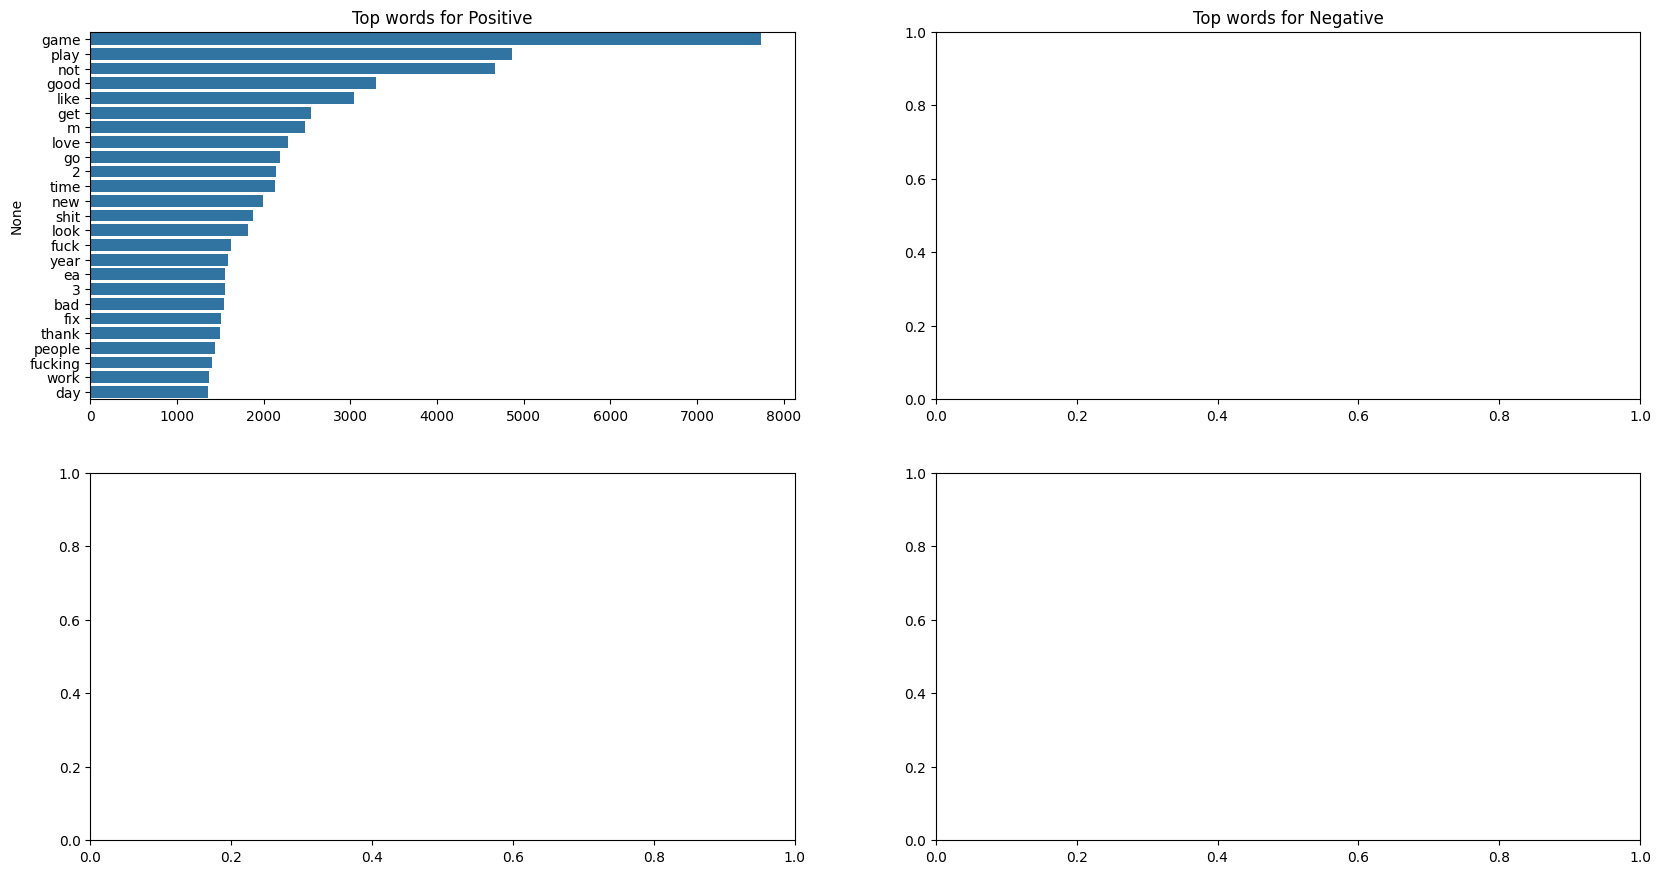

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

# Feature Selection

Elijo las mejores fetures para mi modelo utilizando diferentes metodos como lasso, o Xgboost, Chi cuadrado

# ELECCION DE MODELO

Cada uno de los filtros de texto permite abstraer alguna parte de la informacion de estos, por lo cual en esta parte primero determinaremos cuales son los mas significativos para nuestro modelo, esto lo hacermos de 3 maneras principalmente las cuales son forward stepwise selection, lasso y ridge. Luego vamos a utilizar XGboost

# AJUSTE DE HIPERPARAMETROS

## Training

In [54]:
enc= LabelEncoder()
y_trn= enc.fit_transform(df_trn['sentiment'])
y_tst= enc.transform(df_tst['sentiment'])

#Testing

#Resultados

## Matriz de confusion

## ROC AUC